# Post-hoc Uncertainty Calibration for Domain Drift Scenarios

<br>

## Examplary script for plotting metrics of post-hoc models with gaussian tuning strategy

<br>

In [9]:
import seaborn as sns
import numpy as np
import pandas as pd
from collections import OrderedDict
import os
import matplotlib.pyplot as plt

os.chdir("..")
from source.postevaluation.evaluator import Evaluator
from source.utils.calibration import calculate_expected_calibration_error, calculate_binned_prob_acc_list
import source.utils.utils_plotting_experiments as utils_plot

<br>

### Specify post-hoc models  and a path to elevator storages

In [10]:

#names of post-hoc models
legend_model_names = ["Base","TS","ETS","IRM","IROVA","IROVATS"] 
#main path to results
main_path = "/" #SPECIFY PATH TO RESULTS 

model_specs = [
    [os.path.join(main_path,"Calibration_indomain/Imagenet/ResNet50/Base/"), 'IMAGENET', 'Base', 'ResNet50'],
    [os.path.join(main_path,"Calibration_indomain/Imagenet/ResNet50/TS/"), 'IMAGENET', 'TS', 'ResNet50'],
    [os.path.join(main_path,"Calibration_indomain/Imagenet/ResNet50/ETS/"), 'IMAGENET', 'ETS', 'ResNet50'],
    [os.path.join(main_path,"Calibration_indomain/Imagenet/ResNet50/IROVA/"), 'IMAGENET', 'IROVA', 'ResNet50'],
    [os.path.join(main_path,"Calibration_indomain/Imagenet/ResNet50/IROVATS/"), 'IMAGENET', 'IROVATS', 'ResNet50'],
    [os.path.join(main_path,"Calibration_indomain/Imagenet/ResNet50/IRM/"), 'IMAGENET', 'IRM', 'ResNet50'],
   
    [os.path.join(main_path,"Calibration_ood/Imagenet/ResNet50/Base/"), 'IMAGENET', 'Base-P', 'ResNet50'],
    [os.path.join(main_path,"Calibration_ood/Imagenet/ResNet50/TS/"), 'IMAGENET', 'TS-P', 'ResNet50'],
    [os.path.join(main_path,"Calibration_ood/Imagenet/ResNet50/ETS/"), 'IMAGENET', 'ETS-P', 'ResNet50'],
    [os.path.join(main_path,"Calibration_ood/Imagenet/ResNet50/IROVA/"), 'IMAGENET', 'IROVA-P', 'ResNet50'],
    [os.path.join(main_path,"Calibration_ood/Imagenet/ResNet50/IROVATS/"), 'IMAGENET', 'IROVATS-P', 'ResNet50'],
    [os.path.join(main_path,"Calibration_ood/Imagenet/ResNet50/IRM/"), 'IMAGENET', 'IRM-P', 'ResNet50'],
]


<br>

### Load dataframe for specified post-hoc models

In [11]:
metrics = ["ECE","accuracy"]
data_all = utils_plot.get_data(model_specs, metrics)
data_all = utils_plot.clean_df(data_all)
data_all

,Loss_type,Index,Perturbation,Epsilon,Value,NN,Model,Data,Data_Model_NN
0,accuracy,0,imagenet2012_corrupted_gaussian_noise,0,0.745200,ResNet50,Base,IMAGENET,IMAGENET Base ResNet50
1,ECE,0,imagenet2012_corrupted_gaussian_noise,0,0.062645,ResNet50,Base,IMAGENET,IMAGENET Base ResNet50
25006,accuracy,0,imagenet2012_corrupted_gaussian_noise,1,0.626160,ResNet50,Base,IMAGENET,IMAGENET Base ResNet50
25007,ECE,0,imagenet2012_corrupted_gaussian_noise,1,0.088460,ResNet50,Base,IMAGENET,IMAGENET Base ResNet50
50012,accuracy,0,imagenet2012_corrupted_gaussian_noise,2,0.536400,ResNet50,Base,IMAGENET,IMAGENET Base ResNet50
...,...,...,...,...,...,...,...,...,...
2775667,ECE,0,speckle noise,3,0.051126,ResNet50,IRM-P,IMAGENET,IMAGENET IRM-P ResNet50
2800672,accuracy,0,speckle noise,4,0.290800,ResNet50,IRM-P,IMAGENET,IMAGENET IRM-P ResNet50
2800673,ECE,0,speckle noise,4,0.085957,ResNet50,IRM-P,IMAGENET,IMAGENET IRM-P ResNet50
2825678,accuracy,0,speckle noise,5,0.183120,ResNet50,IRM-P,IMAGENET,IMAGENET IRM-P ResNet50


<br>

### Load dataframe for specified post-hoc models and calculate micro average ECEs

In [12]:
dict_microECE = []
dict_microVUCECE = []
for data in model_specs:
    data_part = utils_plot.get_data([data], ["matches", "confidence_scores"])
    data_part = utils_plot.clean_df(data_part)
    if data_part.empty == False:
        dict_microECE.append(utils_plot.process_micro_ECE(data_part))
        dict_microVUCECE.append(utils_plot.process_micro_vucECE(data_part))
df_microECE = pd.concat(dict_microECE)
df_microVUCECE = pd.concat(dict_microVUCECE) 

df_microECE.insert(len(df_microECE.columns), "Tune_Mode",1)
df_microECE.loc[df_microECE['Model'].apply(lambda x: True if "-P" not in x else False), 'Tune_Mode'] = "Standard Tuning"
df_microECE.loc[df_microECE['Model'].apply(lambda x: True if "-P" in x else False), 'Tune_Mode'] = "Ours"
df_microECE.insert(len(df_microECE.columns), "General_Model",1)
for legend_model_name in legend_model_names:
    df_microECE.loc[df_microECE['Model'].apply(lambda x: True if legend_model_name == x.replace("-P","") else False), 'General_Model'] = legend_model_name

df_microVUCECE.insert(len(df_microVUCECE.columns), "Tune_Mode",1)
df_microVUCECE.loc[df_microVUCECE['Model'].apply(lambda x: True if "-P" not in x else False), 'Tune_Mode'] = "Standard Tuning"
df_microVUCECE.loc[df_microVUCECE['Model'].apply(lambda x: True if "-P" in x else False), 'Tune_Mode'] = "Ours"
df_microVUCECE.insert(len(df_microVUCECE.columns), "General_Model",1)
for legend_model_name in legend_model_names:
    df_microVUCECE.loc[df_microVUCECE['Model'].apply(lambda x: True if legend_model_name == x.replace("-P","") else False), 'General_Model'] = legend_model_name

print(df_microECE)
print(df_microVUCECE)

       Value       Perturbation  Model        Tune_Mode General_Model
0   0.131203        motion blur   Base  Standard Tuning          Base
1   0.158358         glass blur   Base  Standard Tuning          Base
2   0.127824          zoom blur   Base  Standard Tuning          Base
3   0.136079              frost   Base  Standard Tuning          Base
4   0.181615         shot noise   Base  Standard Tuning          Base
..       ...                ...    ...              ...           ...
14  0.037609       defocus blur  IRM-P             Ours           IRM
15  0.026302           contrast  IRM-P             Ours           IRM
16  0.073348      impulse noise  IRM-P             Ours           IRM
17  0.032229  elastic transform  IRM-P             Ours           IRM
18  0.031304            spatter  IRM-P             Ours           IRM

[209 rows x 5 columns]
       Value       Perturbation  Model        Tune_Mode General_Model
0   0.148052        motion blur   Base  Standard Tuning          B

<br>

### Define color palette and model order for figures

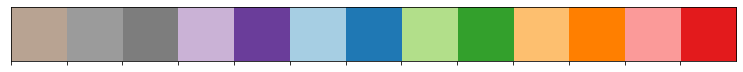

In [14]:
model_order = ["Base","TS","TS-P","ETS","ETS-P","IROVATS","IROVATS-P","IROVA","IROVA-P","IRM","IRM-P"]
tune_mode_order = ("Base","TS","ETS","IROVATS","IROVA","IRM")

sns.set_palette("Set2")

colors = ["#e31a1c","#fb9a99","#ff7f00","#fdbf6f","#33a02c","#b2df8a","#1f78b4","#a6cee3","#6a3d9a","#cab2d6","#7D7D7D","#9B9B9B","#B8A392"]#,"#b15928"]
colors = colors[::-1]
color_dict = OrderedDict(zip(model_order, colors))
sns.palplot(colors)

<br>

## Plots

<br>

### Mean Expected Calibration Error (ECE) 

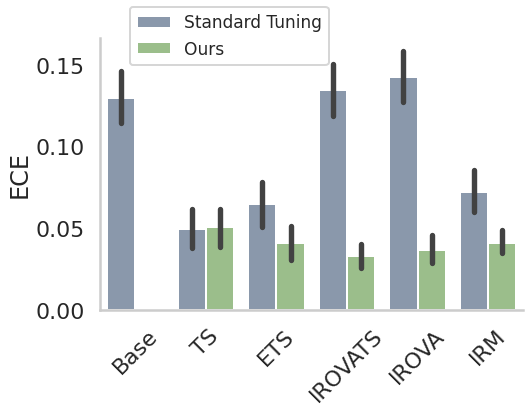

In [22]:
import matplotlib.pylab as plt

df = df_microECE.copy()
df = df.loc[df.Perturbation.isin(["general_gaussian_noise"])==False]
df = df.loc[df.Perturbation.isin(["imagenet2012_corrupted_gaussian_noise"])==False]

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("poster")

ax = sns.catplot(
    x="General_Model",
    y="Value",
    hue="Tune_Mode",
    data=df,
    aspect=1.5, 
    kind="bar",
    palette=("#8497B0","#98C683"),
    order=tune_mode_order, 
    legend=False
)

plt.xticks(rotation=45)
ax.set(xlabel='', ylabel='ECE', title='')
handles, labels = ax.fig.gca().get_legend_handles_labels()
plt.legend(handles=handles[0:], labels=labels[0:], bbox_to_anchor=(.07, 0.9, 0.6, .102),
           borderaxespad=0.,fontsize=17)

<br>

### Dependency of accuracy and ECE on level of domain shift. 

[Text(0.5, 0, 'Epsilon'), Text(0, 0.5, 'Accuracy'), Text(0.5, 1.0, '')]

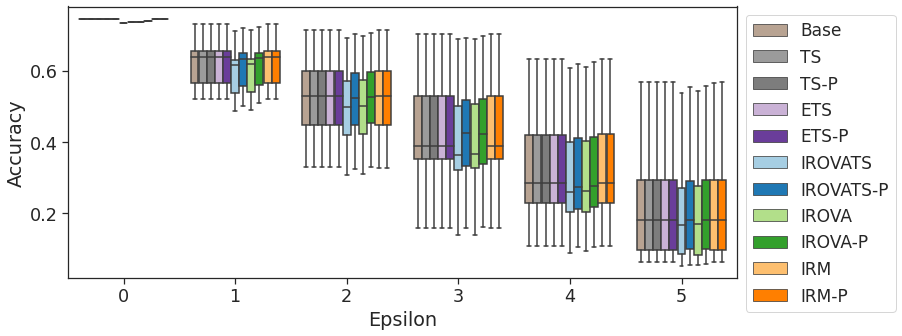

In [23]:
df = data_all.loc[data_all.Loss_type.isin(["accuracy"])]

df = df.loc[df.Perturbation.isin(["general_gaussian_noise"])==False]
df = df.loc[df.Perturbation.isin(["imagenet2012_corrupted_gaussian_noise"])==False]

sns.set(font_scale=1.6)
plt.figure(figsize=(12,5))

with sns.axes_style("ticks"):
    ax = sns.boxplot(
        x="Epsilon",
        y="Value",
        hue="Model",
        data=df,
        hue_order=model_order,
        palette=color_dict,
        saturation=1.0,
    )

h, l = ax.get_legend_handles_labels()
ax.legend(h, l, facecolor='white', fontsize=17, bbox_to_anchor=(1.0, 1.0))

ax.set(xlabel='Epsilon', ylabel='Accuracy', title='')

[Text(0.5, 0, 'Epsilon'), Text(0, 0.5, 'ECE'), Text(0.5, 1.0, '')]

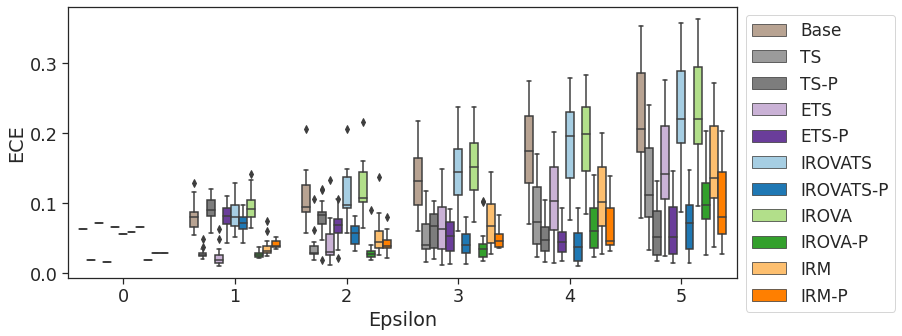

In [24]:
df = data_all.loc[data_all.Loss_type.isin(["ECE"])]

df = df.loc[df.Perturbation.isin(["general_gaussian_noise"])==False]
df = df.loc[df.Perturbation.isin(["imagenet2012_corrupted_gaussian_noise"])==False]

sns.set(font_scale=1.6)
plt.figure(figsize=(12,5))

with sns.axes_style("ticks"):
    ax = sns.boxplot(
        x="Epsilon",
        y="Value",
        hue="Model",
        data=df,
        hue_order=model_order,
        palette=color_dict, 
        saturation=1.0,
    )

h, l = ax.get_legend_handles_labels()
ax.legend(h, l, facecolor='white', fontsize=17, bbox_to_anchor=(1.0, 1.0))
ax.set(xlabel='Epsilon', ylabel='ECE', title='')